In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
plt.rcParams.update({
    'font.size': 18,
    'axes.linewidth':2,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (25,10),
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15,
    'font.family': 'Arial',
    'legend.fontsize':14,
    'axes.labelsize':20,
    'axes.grid':True,
})

In [4]:
from tensorflow.python.client import device_lib
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8406066984900149871
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4177330176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 176906634804568742
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# Importing Buckley Leveritt dataset

In [5]:
U = np.load('Buckley_dataset/Buckley.npy')

X = np.linspace(0,1,len(U))
T = np.linspace(0,1,len(U))
X2, T2 = np.meshgrid(X,T)

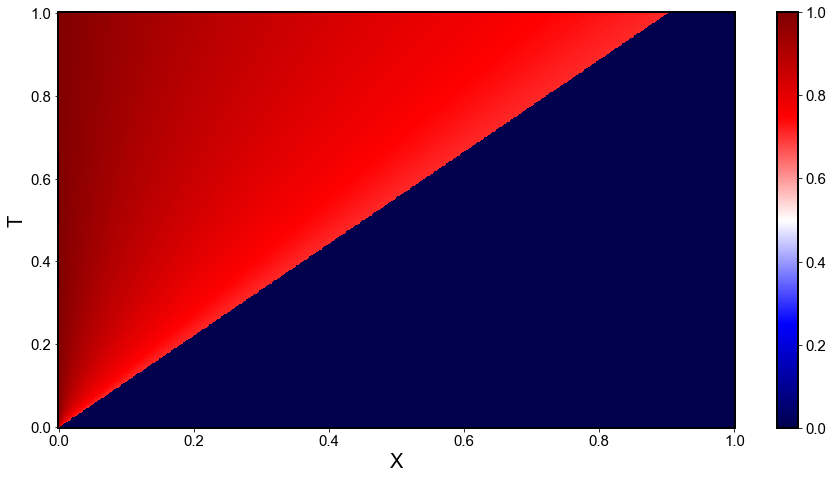

In [6]:
fig, ax = plt.subplots(figsize=(13, 7))

surf = ax.pcolor(X2,T2,U,cmap=plt.get_cmap("seismic"),shading='auto')

fig.colorbar(surf)
plt.xlabel('X')
plt.ylabel('T')
plt.tight_layout()

# PINN - theory

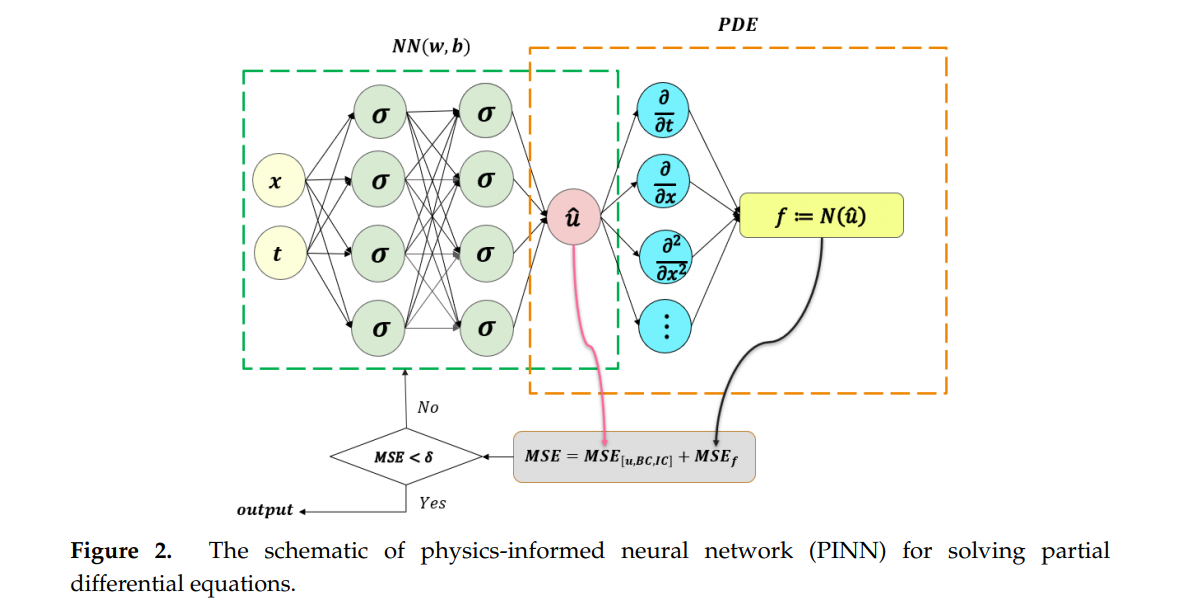

The neural network will try to find a mapping between the independent variables (**x** and **t** in figure 2) and the approximate solution of the differential equation **u**. This approximation will undergoe automatic differentiation to obtain the expression **f** that is equal to the differential equation we would like to solve. In this case:


The shared parameters between the neural network u(t,x) and residual equation f(t,x) can be learned by minimizing the mean squared error loss below:


$$ MSE = MSE_u + MSE_f \tag{5} $$


Where

- $MSE_u:$ = Error associated with the inicial and boundary conditions on **u(t,x)** 
- $MSE_f:$ = Error associated by inforcing the structure of equation **f** at a finite set of collocation points, whose number and location is taken from the same training data.

By definition of **f**, $MSE_u$ should be zero, which indicates there is no residual.

# Sampling 

In [7]:
import random
random.seed(123)

def sample_boundaries(X2,T2,U2,Nleft,Nright,Ninit,N_dom):
    
    
    # Collocation points
    rng = np.random.default_rng()
    t_idx=rng.choice(U2.shape[0],N_dom) # size of time domain
    x_idx=rng.choice(U2.shape[1],N_dom) # size of distance domain
    Xdom = X2[[t_idx,x_idx]]
    Tdom = T2[[t_idx,x_idx]]
    Udom = U2[[t_idx,x_idx]]
    

    left_idx=rng.choice(U2.shape[0],Nleft) 
    Xleft = X2[:,0][left_idx]
    Tleft = T2[:,0][left_idx]
    Uleft = U2[:,0][left_idx]

    #print(Xleft)
    #print(Tleft)
    #print(Uleft)

    right_idx=rng.choice(U2.shape[0],Nright) 
    Xright = X2[:,-1][right_idx]
    Tright = T2[:,-1][right_idx]
    Uright = U2[:,-1][right_idx]

    #print(Xright)
    #print(Tright)
    #print(Uright)

    init_idx=rng.choice(U2.shape[1],Ninit) 
    Xinit = X2[0,:][init_idx]
    Tinit = T2[0,:][init_idx]
    Uinit = U2[0,:][init_idx]
    

    
    return Xleft,Tleft,Uleft,Xright,Tright,Uright,Xinit,Tinit,Uinit,Xdom,Tdom,Udom

Xleft,Tleft,Uleft,Xright,Tright,Uright,Xinit,Tinit,Uinit,Xdom,Tdom,Udom = sample_boundaries(X2,T2,U,Nleft=300,Nright=300,Ninit=300,N_dom=10000)

In [8]:
#plt.scatter(Xleft,Tleft,s=50, color='black', marker='x')
#plt.scatter(Xright,Tright,s=50, color='black', marker='x')
#plt.scatter(Xinit,Tinit,s=50, color='black', marker='x')

#plt.scatter(Xdom,Tdom,s=10, color='red', marker='x',alpha=0.4)

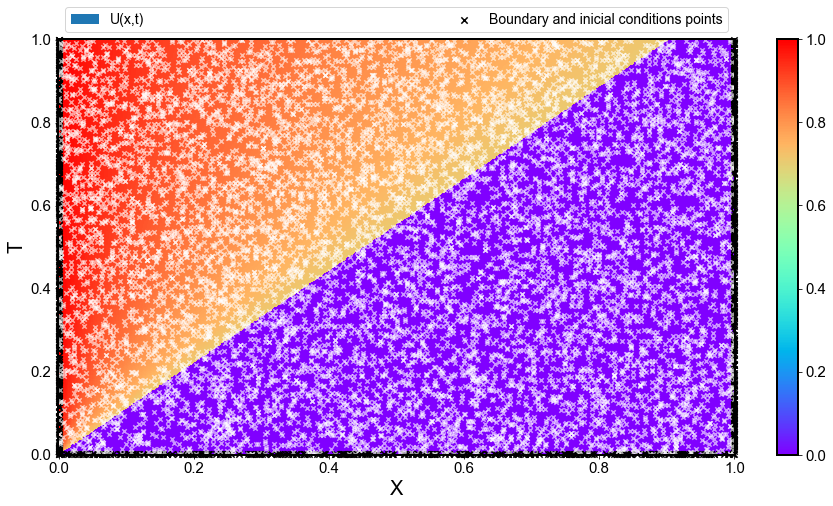

In [9]:
fig, ax = plt.subplots(figsize=(13, 7))

surf = ax.pcolor(X,T,U,cmap=plt.get_cmap("rainbow"),shading='auto')
fig.colorbar(surf)

plt.scatter(Xleft,Tleft,s=40,  marker='x',clip_on = False,c='black')
plt.scatter(Xright,Tright,s=40,  marker='x',clip_on = False,c='black')
plt.scatter(Xinit,Tinit,s=40,  marker='x',clip_on = False,c='black')
plt.scatter(Xdom,Tdom,s=20,  marker='x',alpha=0.6,c='white')

plt.xlabel('X')
plt.ylabel('T')
plt.tight_layout()
plt.legend(['U(x,t)','Boundary and inicial conditions points'],bbox_to_anchor=(0, 1, 1, 0), loc="lower right", mode="expand", ncol=2)

# Neural network 

In [10]:
import sciann as sn

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


In [11]:
# Define independent variables
x = sn.Variable("x", dtype='float64')
t = sn.Variable("t", dtype='float64')
u = sn.Field("u",dtype='float64')

In [12]:
# Define the neural network arquitecture to produce the solution U
u2 = sn.Functional(fields='u',               # output of the neural network
                  variables=[x, t],          # input variables
                  hidden_layers=[20]*8,      # Same architecture as the main reference 
                  activation='l-tanh')       # adaptive activation function ('l-')    

# Defining the Buckley-Leverett equation - without diffusion and concave flux

Writting the equation:

$$ u_t + (f_w)_x = 0 $$

Where:

$$ f_w = \frac{u}{u + \frac{(1-u)}{M}} $$ 

In [13]:
M = 2 # Make tge flux function concave 
fw = u2 / (u2 + (1-u2)/M)  # flux function

u_t = sn.diff(u2, t)
fw_x = sn.diff(fw, x)

f = u_t + fw_x
f = sn.rename(f,'PINN')

## Defining the PINN model

In [14]:
m = sn.SciModel(inputs=[x,t],
                targets=[u2,f], # Model must minimize the neural network loss "U" and the PINN loss "f"
                loss_func='mse',
                optimizer='adam',
                #load_weights_from = 'Kuramoto_weights.h5',
                plot_to_file='Kuramoto_network.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


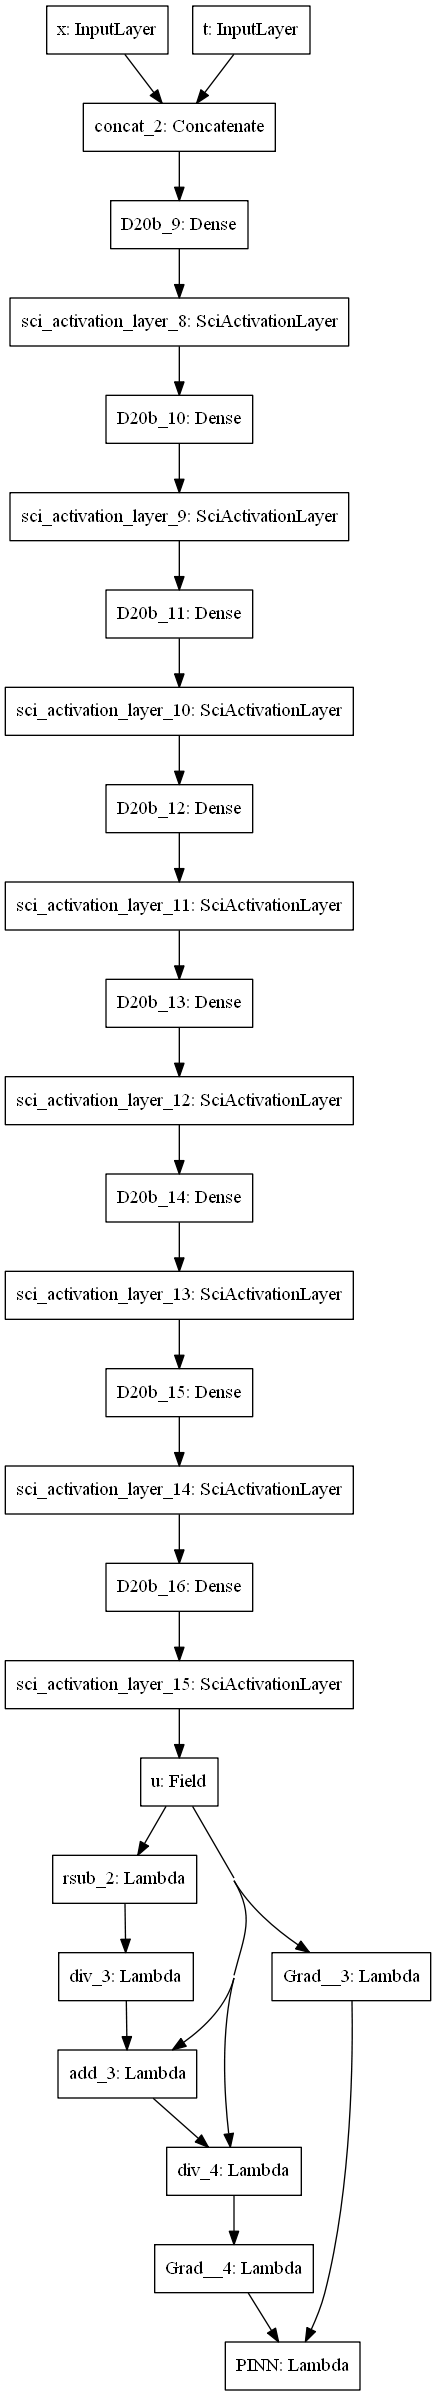

In [15]:
from IPython.display import Image
Image(filename='Kuramoto_network.png')  # Neural network arquitecture

## Creating the dataset

In [16]:
X_train = np.concatenate([Xdom.reshape(-1,1),Xleft.reshape(-1,1),Xright.reshape(-1,1),Xinit.reshape(-1,1)])
T_train = np.concatenate([Tdom.reshape(-1,1),Tleft.reshape(-1,1),Tright.reshape(-1,1),Tinit.reshape(-1,1)])
U_train = np.concatenate([Udom.reshape(-1,1),Uleft.reshape(-1,1),Uright.reshape(-1,1),Uinit.reshape(-1,1)])


#X_train = np.concatenate([Xdom.reshape(-1,tunits,1),Xleft.reshape(-1,tunits,1),Xright.reshape(-1,tunits,1),Xinit.reshape(-1,tunits,1)])
#T_train = np.concatenate([Tdom.reshape(-1,tunits,1),Tleft.reshape(-1,tunits,1),Tright.reshape(-1,tunits,1),Tinit.reshape(-1,tunits,1)])
#U_train = np.concatenate([Udom.reshape(-1,tunits,1),Uleft.reshape(-1,tunits,1),Uright.reshape(-1,tunits,1),Uinit.reshape(-1,tunits,1)])

In [17]:
ids_dom = np.arange(0,Xdom.size) # index for colocation points
ids_bc_ic = np.arange(ids_dom.size,X_train.size) # index for boundary and initial conditions
ids = np.concatenate([ids_dom,ids_bc_ic])

#ids
#print(ids_dom)
#print('')
#print(ids_phys)

## Train the model

In [18]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='PINN_loss',patience=15,mode='min',verbose=1)

my_callbacks = [early_stopping]

h = m.train([X_train,T_train], # random collocation points inside the domain
            [(ids_bc_ic,U_train[ids_bc_ic]),(ids_dom,U_train[ids_dom])], 
            epochs=1000,
            batch_size=64,
            learning_rate=0.001,
            reduce_lr_after=100, #  Reduce learning rate after every 100 epochs
            stop_loss_value = 1e-8,
            callbacks=my_callbacks
            )           


Total samples: 10900 
Batch size: 64 
Total batches: 171 

Epoch 1/1000
171/171 [==============================] - 6s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.3240 - u_loss: 0.2036 - PINN_loss: 0.1204
Epoch 2/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0516 - u_loss: 0.0304 - PINN_loss: 0.0212
Epoch 3/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0404 - u_loss: 0.0233 - PINN_loss: 0.0171
Epoch 4/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0371 - u_loss: 0.0209 - PINN_loss: 0.0163
Epoch 5/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0343 - u_loss: 0.0201 - PINN_loss: 0.0142
Epoch 6/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0334 - u_loss: 0.0191 - PINN_loss: 0.0143
Epoch 7/1000
171

In [19]:
m.save_weights('Kuramoto_weights.h5')

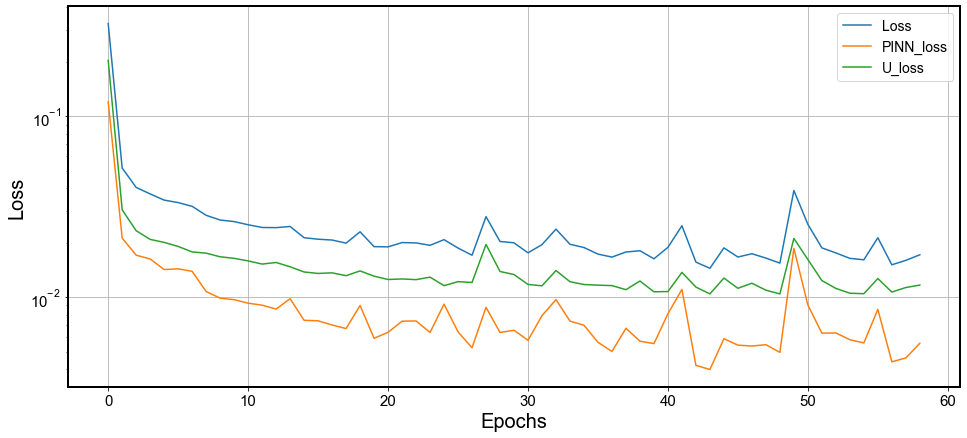

In [20]:
plt.figure(figsize=(16,7))

plt.semilogy(h.history['loss'],label='Loss')
plt.semilogy(h.history['PINN_loss'],label='PINN_loss')
plt.semilogy(h.history['u_loss'],label='U_loss')

#plt.plot(h.history['loss'],label='Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [21]:
U_pred = f.eval(m,[X2, T2])
U_pred
print(U_pred.shape)

(500, 500)


Mean absolute error (MAE): 0.035686381566335044


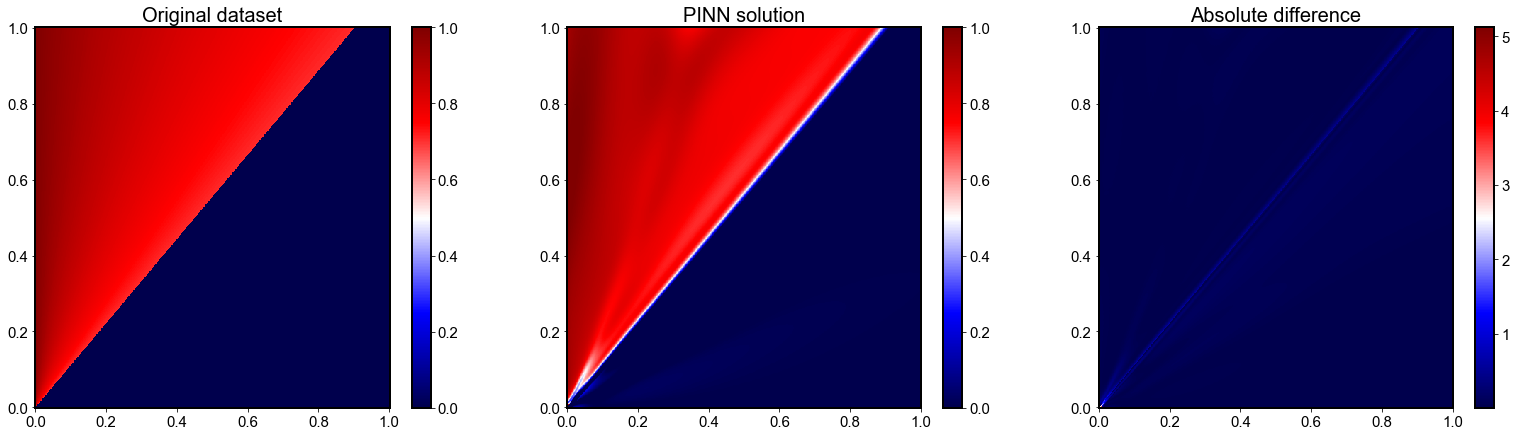

In [22]:
plt.figure(figsize=(27,7))

vmin = U.min().min()
vmax = U.max().max()

plt.subplot(1,3,1)
im=plt.pcolor(X2,T2,U,cmap=plt.get_cmap("seismic"),shading='auto')
plt.colorbar(im)
plt.title('Original dataset')


plt.subplot(1,3,2)
im = plt.pcolor(X2,T2,U_pred,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin,vmax=vmax)
plt.colorbar(im)
plt.title('PINN solution')

plt.subplot(1,3,3)
diff = abs(U_pred-U)
im=plt.pcolor(X,T,diff,cmap=plt.get_cmap("seismic"),shading='auto') # absolute error
plt.colorbar(im)
plt.title('Absolute difference')

print('Mean absolute error (MAE): {}'.format(diff.mean()))

# Buckley-Leverett equation - Non-convex flux function

Writing the equation:
$$ u_t + (f_w)_x = 0 $$

Where:

$$ f_w = \frac{u^2}{u^2 + \frac{(1-u)^2}{M}} $$ 

In [23]:
M = 1 
fw = u2**2 / (u2**2 + ((1-u2)**2)/M)  # flux function

u_t = sn.diff(u2, t)
fw_x = sn.diff(fw, x)

f2 = u_t + fw_x
f2 = sn.rename(f,'PINN')

In [24]:
m2 = sn.SciModel(inputs=[x,t],
                targets=[u2,f2], # Model must minimize the neural network loss "U" and the PINN loss "f"
                loss_func='mse',
                optimizer='adam',
                #load_weights_from = 'Kuramoto_weights.h5',
                plot_to_file='Kuramoto_network.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [25]:
# Train the model

h2 = m2.train([X_train,T_train], # random collocation points inside the domain
            [(ids_bc_ic,U_train[ids_bc_ic]),(ids_dom,U_train[ids_dom])], 
            epochs=1000,
            batch_size=64,
            learning_rate=0.001,
            reduce_lr_after=100, #  Reduce learning rate after every 100 epochs
            stop_loss_value = 1e-8,
            callbacks=my_callbacks
            )          


Total samples: 10900 
Batch size: 64 
Total batches: 171 

Epoch 1/1000
171/171 [==============================] - 5s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0171 - u_loss: 0.0112 - PINN_loss: 0.0059
Epoch 2/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0217 - u_loss: 0.0112 - PINN_loss: 0.0106
Epoch 3/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0242 - u_loss: 0.0187 - PINN_loss: 0.0055
Epoch 4/1000
171/171 [==============================] - 4s 22ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0174 - u_loss: 0.0126 - PINN_loss: 0.0049
Epoch 5/1000
171/171 [==============================] - 4s 22ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0146 - u_loss: 0.0109 - PINN_loss: 0.0037
Epoch 6/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0158 - u_loss: 0.0104 - PINN_loss: 0.0055
Epoch 7/1000
171

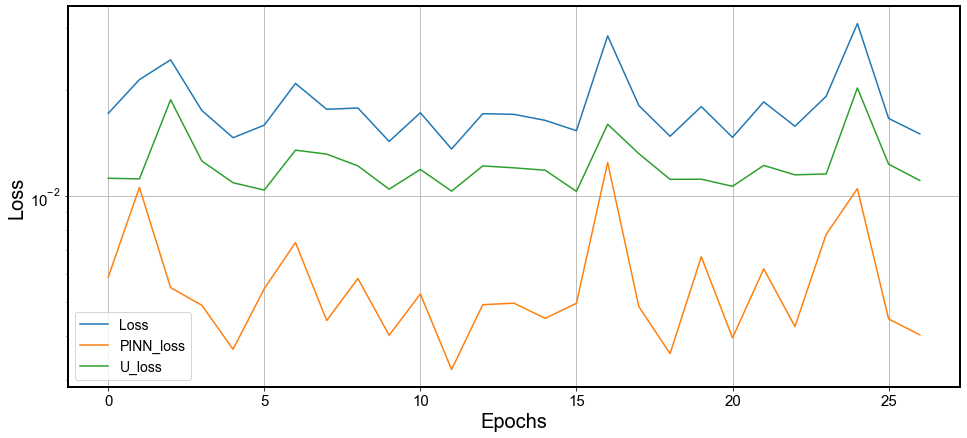

In [26]:
plt.figure(figsize=(16,7))

plt.semilogy(h2.history['loss'],label='Loss')
plt.semilogy(h2.history['PINN_loss'],label='PINN_loss')
plt.semilogy(h2.history['u_loss'],label='U_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Mean absolute error (MAE): 0.04377776969057405


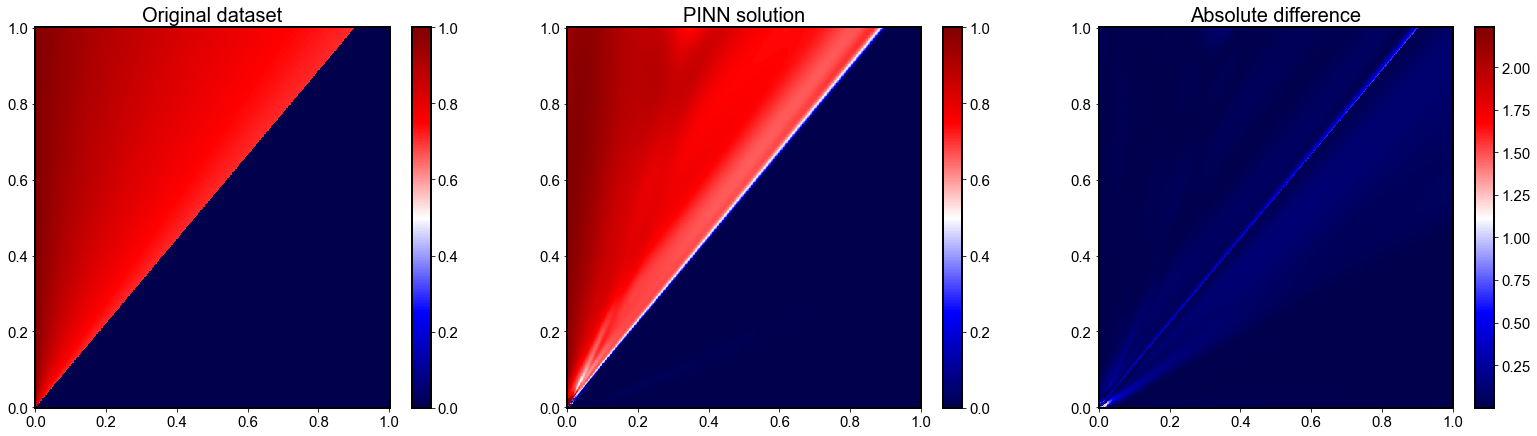

In [27]:
U_pred = f2.eval(m,[X2, T2])

plt.figure(figsize=(27,7))

vmin = U.min().min()
vmax = U.max().max()

plt.subplot(1,3,1)
im=plt.pcolor(X2,T2,U,cmap=plt.get_cmap("seismic"),shading='auto')
plt.colorbar(im)
plt.title('Original dataset')


plt.subplot(1,3,2)
im = plt.pcolor(X2,T2,U_pred,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin,vmax=vmax)
plt.colorbar(im)
plt.title('PINN solution')

plt.subplot(1,3,3)
diff = abs(U_pred-U)
im=plt.pcolor(X,T,diff,cmap=plt.get_cmap("seismic"),shading='auto') # absolute error
plt.colorbar(im)
plt.title('Absolute difference')

print('Mean absolute error (MAE): {}'.format(diff.mean()))

# Buckley-Leverett equation - with diffusion term and non-convex flux function

Writing the equation:
$$ u_t + u_x*(f_w)_x -eu_{xx}= 0 $$

Where:

$$ f_w = \frac{u^2}{u^2 + \frac{(1-u)^2}{M}} $$ 
$$ e = 2.5*10^{-3}$$

In [28]:
M = 1 
e = 2.5e-3
fw = u2**2 / (u2**2 + ((1-u2)**2)/M)  # flux function

u_t = sn.diff(u2, t)
u_x = sn.diff(u2, x)
u_xx = sn.diff(u2, x,order=2)
fw_x = sn.diff(fw, x)

f3 = u_t + fw_x*u_x -e*u_xx
f3 = sn.rename(f,'PINN')

In [29]:
m3 = sn.SciModel(inputs=[x,t],
                targets=[u2,f3], # Model must minimize the neural network loss "U" and the PINN loss "f"
                loss_func='mse',
                optimizer='adam',
                #load_weights_from = 'Kuramoto_weights.h5',
                plot_to_file='Kuramoto_network.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [30]:
# Train the model

h3 = m3.train([X_train,T_train], # random collocation points inside the domain
            [(ids_bc_ic,U_train[ids_bc_ic]),(ids_dom,U_train[ids_dom])], 
            epochs=1000,
            batch_size=64,
            learning_rate=0.001,
            reduce_lr_after=100, #  Reduce learning rate after every 100 epochs
            stop_loss_value = 1e-8,
            callbacks=my_callbacks
            )          


Total samples: 10900 
Batch size: 64 
Total batches: 171 

Epoch 1/1000
171/171 [==============================] - 6s 25ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0156 - u_loss: 0.0110 - PINN_loss: 0.0046
Epoch 2/1000
171/171 [==============================] - 4s 23ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0149 - u_loss: 0.0101 - PINN_loss: 0.0048
Epoch 3/1000
171/171 [==============================] - 4s 23ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0178 - u_loss: 0.0114 - PINN_loss: 0.0065
Epoch 4/1000
171/171 [==============================] - 4s 22ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0154 - u_loss: 0.0104 - PINN_loss: 0.0051
Epoch 5/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0187 - u_loss: 0.0128 - PINN_loss: 0.0059
Epoch 6/1000
171/171 [==============================] - 4s 22ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0154 - u_loss: 0.0115 - PINN_loss: 0.0040
Epoch 7/1000
171

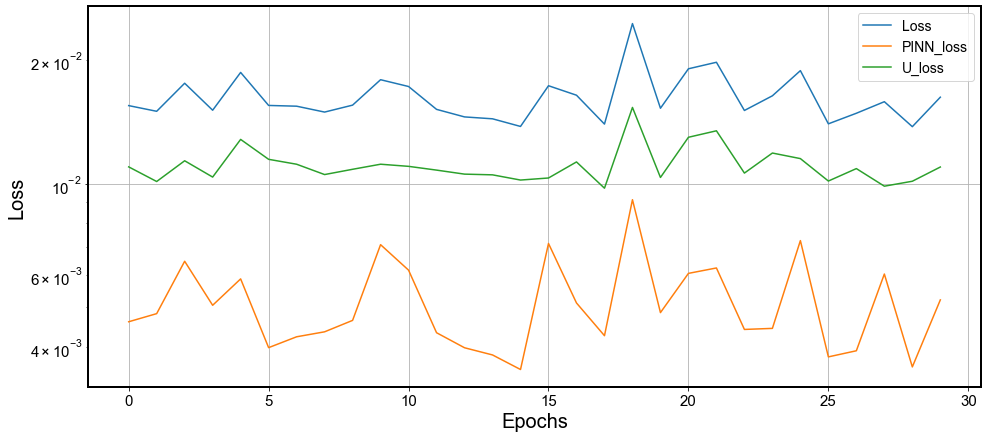

In [31]:
plt.figure(figsize=(16,7))

plt.semilogy(h3.history['loss'],label='Loss')
plt.semilogy(h3.history['PINN_loss'],label='PINN_loss')
plt.semilogy(h3.history['u_loss'],label='U_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Mean absolute error (MAE): 0.0641368959200069


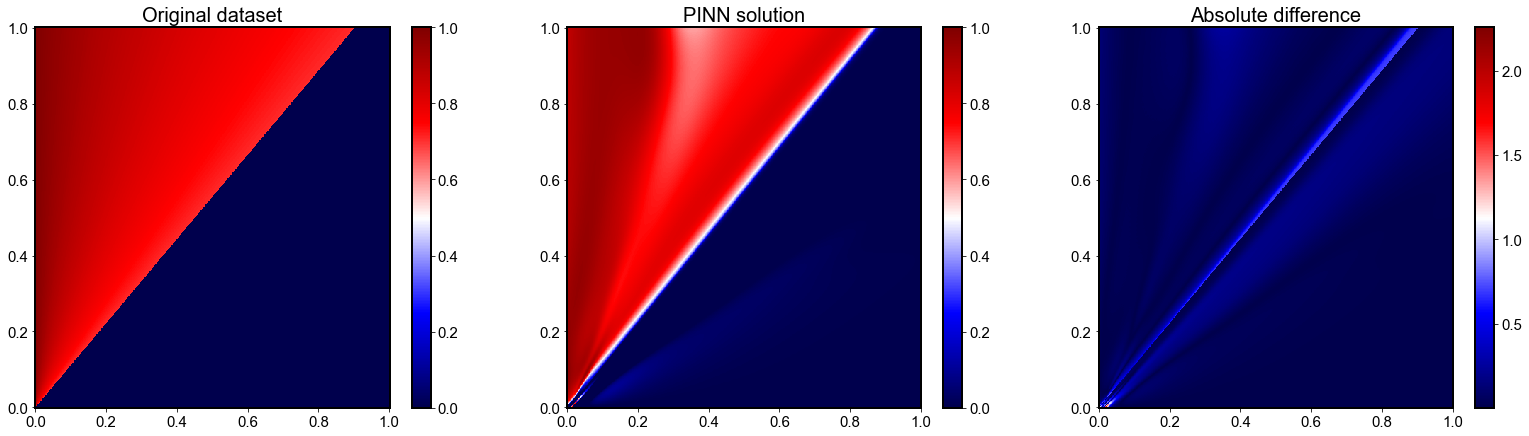

In [32]:
U_pred = f3.eval(m,[X2, T2])

plt.figure(figsize=(27,7))

vmin = U.min().min()
vmax = U.max().max()

plt.subplot(1,3,1)
im=plt.pcolor(X2,T2,U,cmap=plt.get_cmap("seismic"),shading='auto')
plt.colorbar(im)
plt.title('Original dataset')


plt.subplot(1,3,2)
im = plt.pcolor(X2,T2,U_pred,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin,vmax=vmax)
plt.colorbar(im)
plt.title('PINN solution')

plt.subplot(1,3,3)
diff = abs(U_pred-U)
im=plt.pcolor(X,T,diff,cmap=plt.get_cmap("seismic"),shading='auto') # absolute error
plt.colorbar(im)
plt.title('Absolute difference')

print('Mean absolute error (MAE): {}'.format(diff.mean()))

# Buckley-Leverett equation - with diffusion term and convex flux function

Writing the equation:
$$ u_t + u_x*(f_w)_x -eu_{xx}= 0 $$

Where:

$$ f_w = u^2 $$ 
$$ e = 2.5*10^{-3}$$

In [34]:
M = 1 
e = 2.5e-3
fw = u2**2  # flux function - quadratic

u_t = sn.diff(u2, t)
u_x = sn.diff(u2, x)
u_xx = sn.diff(u2, x,order=2)
fw_x = sn.diff(fw, x)

f4 = u_t + fw_x*u_x -e*u_xx
f4 = sn.rename(f,'PINN')

In [35]:
m4 = sn.SciModel(inputs=[x,t],
                targets=[u2,f4], # Model must minimize the neural network loss "U" and the PINN loss "f"
                loss_func='mse',
                optimizer='adam',
                #load_weights_from = 'Kuramoto_weights.h5',
                plot_to_file='Kuramoto_network.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [36]:
# Train the model

h4 = m4.train([X_train,T_train], # random collocation points inside the domain
            [(ids_bc_ic,U_train[ids_bc_ic]),(ids_dom,U_train[ids_dom])], 
            epochs=1000,
            batch_size=64,
            learning_rate=0.001,
            reduce_lr_after=100, #  Reduce learning rate after every 100 epochs
            stop_loss_value = 1e-8,
            callbacks=my_callbacks
            )          


Total samples: 10900 
Batch size: 64 
Total batches: 171 

Epoch 1/1000
171/171 [==============================] - 5s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0161 - u_loss: 0.0105 - PINN_loss: 0.0057
Epoch 2/1000
171/171 [==============================] - 4s 22ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0168 - u_loss: 0.0103 - PINN_loss: 0.0065
Epoch 3/1000
171/171 [==============================] - 4s 22ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0195 - u_loss: 0.0125 - PINN_loss: 0.0070
Epoch 4/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0134 - u_loss: 0.0102 - PINN_loss: 0.0032
Epoch 5/1000
171/171 [==============================] - 4s 21ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0139 - u_loss: 0.0103 - PINN_loss: 0.0036
Epoch 6/1000
171/171 [==============================] - 4s 22ms/step - batch: 85.0000 - size: 63.7427 - loss: 0.0151 - u_loss: 0.0105 - PINN_loss: 0.0045
Epoch 7/1000
171

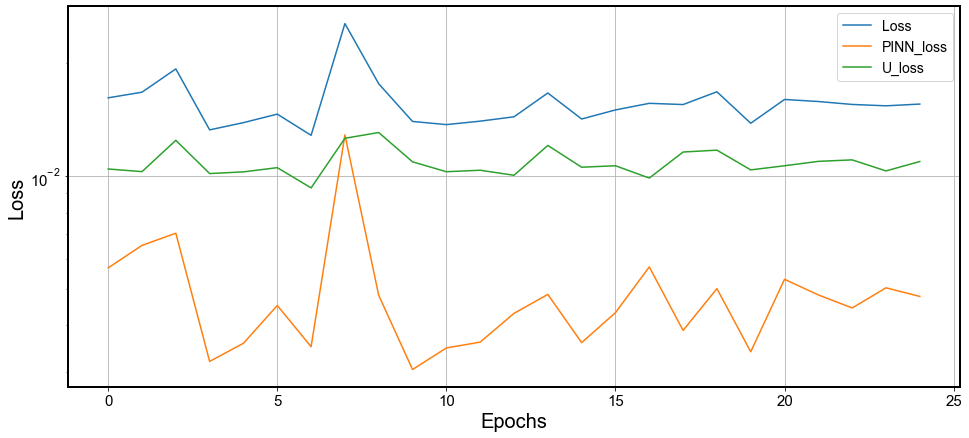

In [37]:
plt.figure(figsize=(16,7))

plt.semilogy(h4.history['loss'],label='Loss')
plt.semilogy(h4.history['PINN_loss'],label='PINN_loss')
plt.semilogy(h4.history['u_loss'],label='U_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Mean absolute error (MAE): 0.0755133269957598


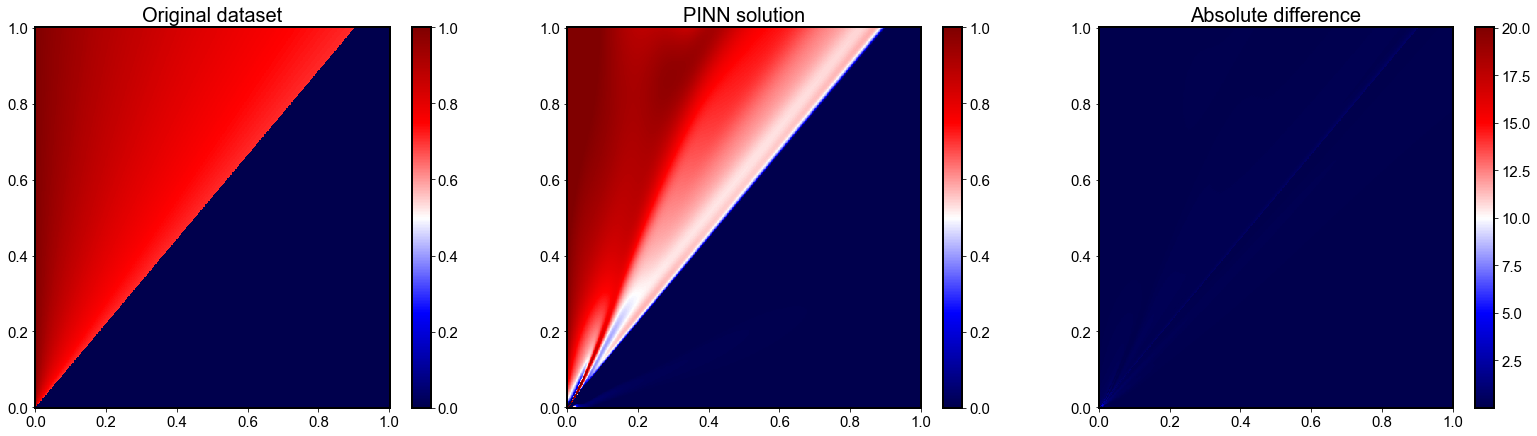

In [38]:
U_pred = f3.eval(m,[X2, T2])

plt.figure(figsize=(27,7))

vmin = U.min().min()
vmax = U.max().max()

plt.subplot(1,3,1)
im=plt.pcolor(X2,T2,U,cmap=plt.get_cmap("seismic"),shading='auto')
plt.colorbar(im)
plt.title('Original dataset')


plt.subplot(1,3,2)
im = plt.pcolor(X2,T2,U_pred,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin,vmax=vmax)
plt.colorbar(im)
plt.title('PINN solution')

plt.subplot(1,3,3)
diff = abs(U_pred-U)
im=plt.pcolor(X,T,diff,cmap=plt.get_cmap("seismic"),shading='auto') # absolute error
plt.colorbar(im)
plt.title('Absolute difference')

print('Mean absolute error (MAE): {}'.format(diff.mean()))

# Conclusions

- The proposed PINN only modeled adequatly the first problem of the four, as seen by the convergence curves;
- There is a lot of difficulty in the shock region. Better allocation of points near this region would lead to better results instead of random distributions.

# References

- Limitations of Physics Informed Machine Learning for Nonlinear Two-Phase Transport in Porous Media